In [1]:
from Utils.DataPreprocessing import split_data, data_cleaning, glove_embedding
import torch
from torch import nn
from torch.utils.data import IterableDataset, Dataset
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import GloVe, vocab, build_vocab_from_iterator
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import os
from torch.nn import functional as F

In [2]:
random_seed = 0
training_set_size = 0.8
GLOVE_TXT_PATH = '../../GloVe Embeddings/glove.840B.300d.txt'
MAX_TOKEN_NBS = 1500 # max number of tokens in each review

In [3]:
imdb_data = pd.read_csv('Data/IMDB Dataset.csv')
imdb_data = data_cleaning(imdb_data)
train_set, test_set = split_data(imdb_data, training_set_size, random_seed)

/mnt/i/Projects/evaluation-deeplearning-NLP/Utils/DataPreprocessing.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset['review'] = dataset['review'].str.replace('<.*?>', '')


In [4]:
train_set.describe()

,sentiment
count,40000.000000
mean,0.500875
std,0.500005
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [5]:
test_set.describe()

,sentiment
count,10000.000000
mean,0.496500
std,0.500013
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [6]:
if os.path.isdir("./.vector_cache"):
    glove_vectors = GloVe(name = '840B', cache = './.vector_cache')
else:
    glove_vectors = GloVe('840B')

In [7]:
glove_vectors

In [8]:
pad_token = "<pad>"
glove_vocab = vocab(glove_vectors.stoi)
glove_vocab.insert_token("<pad>", 0)
# This is necessary otherwise it will throw runtime error if OOV token is queried
glove_vocab.set_default_index(0)
pretrained_embeddings = glove_vectors.vectors
pretrained_embeddings = torch.cat((torch.zeros(1,pretrained_embeddings.shape[1]),pretrained_embeddings))

In [9]:
tokenizer = get_tokenizer("basic_english")

class MyDataset(Dataset):
    def __init__(self, dataframe, max_len=1500, pad_token='<pad>'):
         self.X = dataframe['review'].values
         self.Y = dataframe['sentiment'].to_numpy()
         self.max_len = max_len
         self.pad_token = pad_token

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        t = idx
        tokens = tokenizer(self.X[t])[:self.max_len]
        diff = self.max_len - len(tokens)
        if diff > 0:
            tokens =  tokens + [self.pad_token] * diff
        indices = glove_vocab(tokens)
        result = {
            'text': tokens,
            'indices': torch.tensor(indices),
            'labels': torch.tensor(self.Y[t], dtype=torch.float)
        }
        return result

In [10]:
train_dataset = MyDataset(train_set, MAX_TOKEN_NBS)
test_dataset = MyDataset(test_set, MAX_TOKEN_NBS)

In [11]:
for idx, data in enumerate(train_dataset):
    print("---------------------------------")
    print('next example id ', idx)
    example_text = data['text']
    print(example_text)
    print(data['labels'])
    break


---------------------------------
next example id  0
['that', 'is', 'about', 'the', 'only', 'redeeming', 'quality', 'in', 'a', 'movie', 'that', 'otherwise', 'insults', 'the', 'viewer', "'", 's', 'intelligence', 'by', 'losing', 'track', 'of', 'time', ',', 'plot', ',', 'and', 'reason', 'for', 'being', 'produced', '.', 'plus', ',', 'how', 'that', 'guy', 'with', 'the', 'glasses', 'ever', 'got', 'a', 'gig', 'in', 'hollywood', 'is', 'beyond', 'me', '.', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>',

In [12]:
class TextClassificationModel(nn.Module):
    def __init__(self, pretrained_embeddings, num_class,  freeze_embeddings = True):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze = freeze_embeddings, sparse=False)
        self.conv3 = nn.Conv2d(1, 1, (3, 300))
        self.conv4 = nn.Conv2d(1, 1, (4, 300))
        self.conv5 = nn.Conv2d(1, 1, (5, 300))
        self.Max3_pool = nn.MaxPool2d((1500-3+1, 1))
        self.Max4_pool = nn.MaxPool2d((1500-4+1, 1))
        self.Max5_pool = nn.MaxPool2d((1500-5+1, 1))
        self.linear1 = nn.Linear(3, num_class)


    def forward(self, indices):

        batch = indices.shape[0]

        x = self.embedding(indices.T)
        x = x[None, :]

        x = x.permute(2,0,1,3)

        # Convolution
        x1 = F.relu(self.conv3(x))
        x2 = F.relu(self.conv4(x))
        x3 = F.relu(self.conv5(x))

        # Pooling
        x1 = self.Max3_pool(x1)
        x2 = self.Max4_pool(x2)
        x3 = self.Max5_pool(x3)

        x = torch.cat((x1, x2, x3), -1)
        x = x.view(batch, 1, -1)
        out = self.linear1(x)

        return out

In [13]:
from torch.utils.data import DataLoader

BATCH_SIZE = 256

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [14]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

Epoch: 0 Train_Loss: 0.7336498753280397 Train_Accuracy: 0.510825
Epoch: 0 Test_Loss: 0.7227360099554062 Test_Accuracy: 0.5182


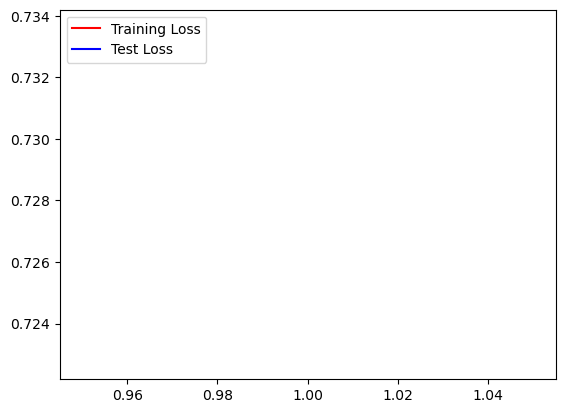

Epoch: 1 Train_Loss: 0.7117295151303529 Train_Accuracy: 0.5204
Epoch: 1 Test_Loss: 0.7048422157764435 Test_Accuracy: 0.5079


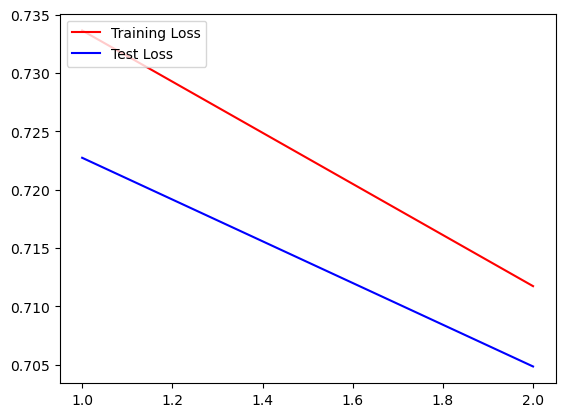

Epoch: 2 Train_Loss: 0.6972243079713955 Train_Accuracy: 0.5034
Epoch: 2 Test_Loss: 0.693086352944374 Test_Accuracy: 0.5053


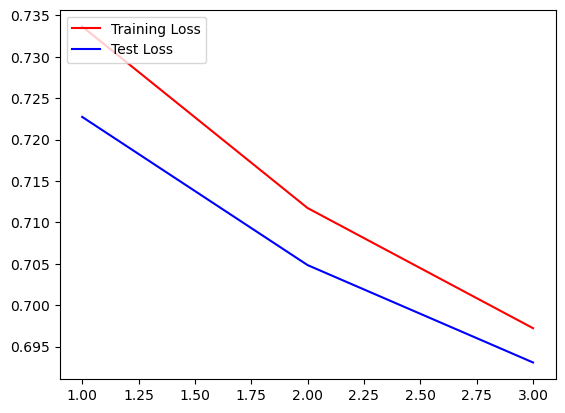

Epoch: 3 Train_Loss: 0.687736371899866 Train_Accuracy: 0.500375
Epoch: 3 Test_Loss: 0.6861882895231247 Test_Accuracy: 0.5047


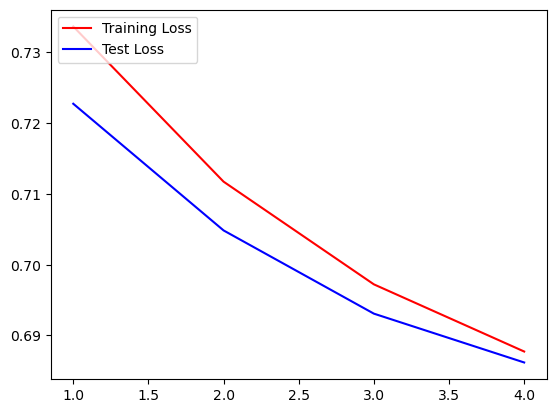

Epoch: 4 Train_Loss: 0.6825254882217213 Train_Accuracy: 0.499825
Epoch: 4 Test_Loss: 0.6823673292994499 Test_Accuracy: 0.5043


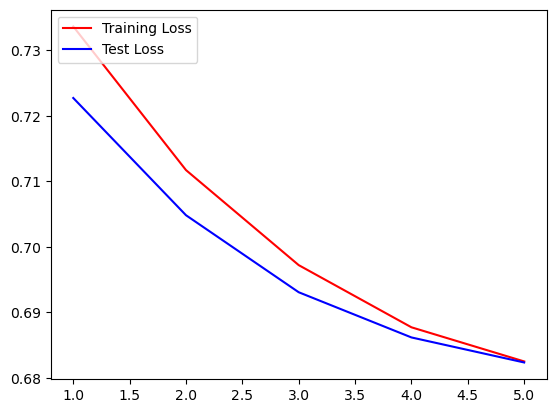

Epoch: 5 Train_Loss: 0.679306985845991 Train_Accuracy: 0.49965
Epoch: 5 Test_Loss: 0.6798260658979416 Test_Accuracy: 0.5044


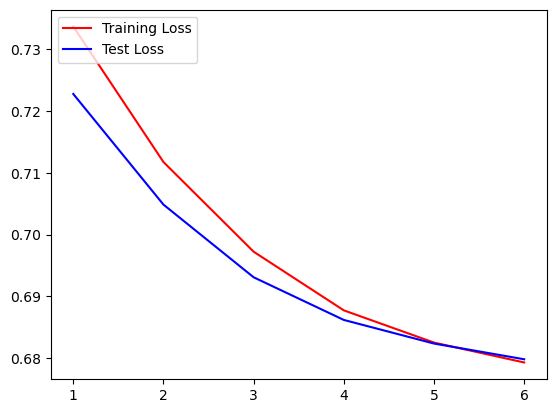

Epoch: 6 Train_Loss: 0.6766979595658126 Train_Accuracy: 0.499625
Epoch: 6 Test_Loss: 0.6777258977293968 Test_Accuracy: 0.5044


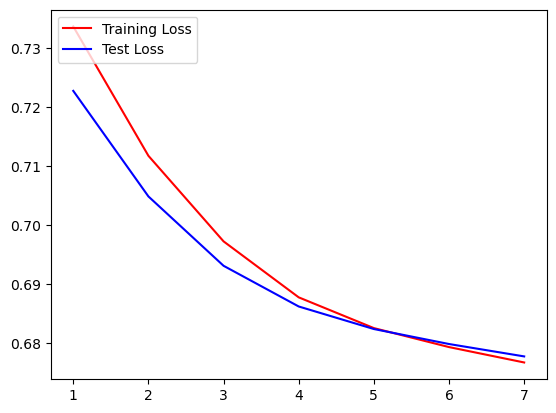

Epoch: 7 Train_Loss: 0.6745084725367795 Train_Accuracy: 0.49975
Epoch: 7 Test_Loss: 0.6757219702005386 Test_Accuracy: 0.5043


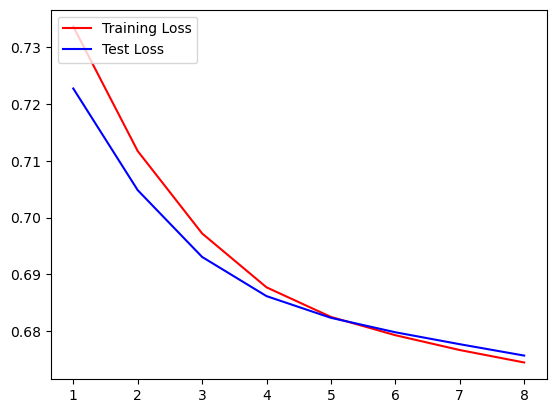

Epoch: 8 Train_Loss: 0.672175894876954 Train_Accuracy: 0.499725
Epoch: 8 Test_Loss: 0.6736586034297943 Test_Accuracy: 0.5043


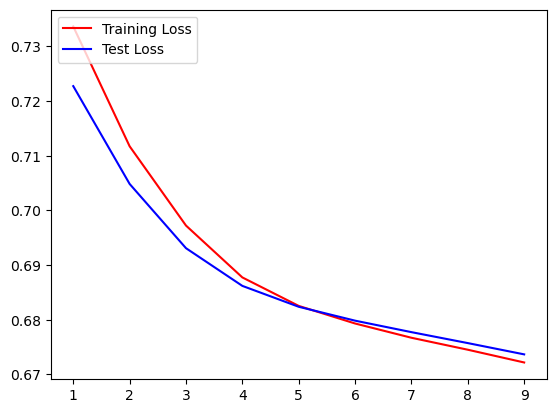

Epoch: 9 Train_Loss: 0.669896873319225 Train_Accuracy: 0.499925
Epoch: 9 Test_Loss: 0.6714642271399498 Test_Accuracy: 0.5043


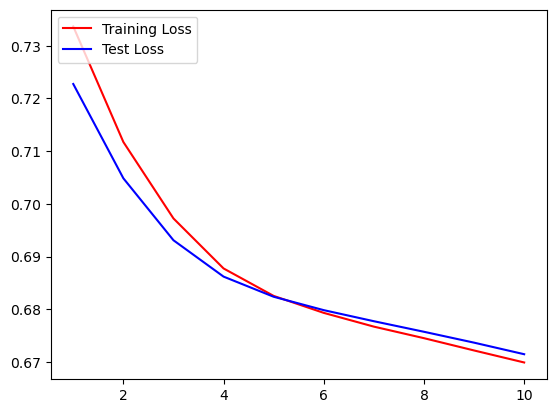

Epoch: 10 Train_Loss: 0.6674442344410404 Train_Accuracy: 0.500025
Epoch: 10 Test_Loss: 0.6691899567842483 Test_Accuracy: 0.5043


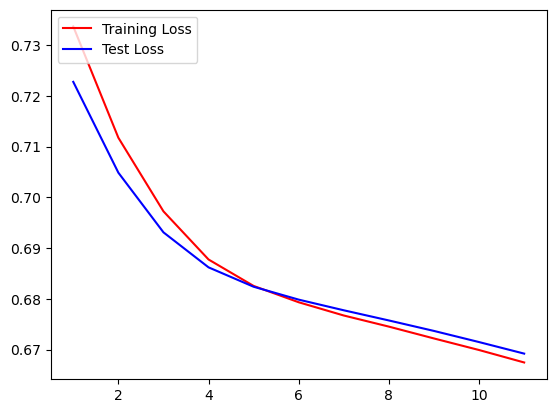

Epoch: 11 Train_Loss: 0.6650412276292302 Train_Accuracy: 0.5001
Epoch: 11 Test_Loss: 0.6670084565877914 Test_Accuracy: 0.5043


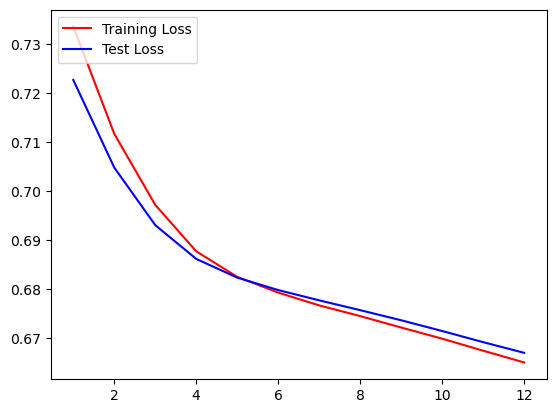

Epoch: 12 Train_Loss: 0.662609074146125 Train_Accuracy: 0.50035
Epoch: 12 Test_Loss: 0.6649174585938453 Test_Accuracy: 0.5045


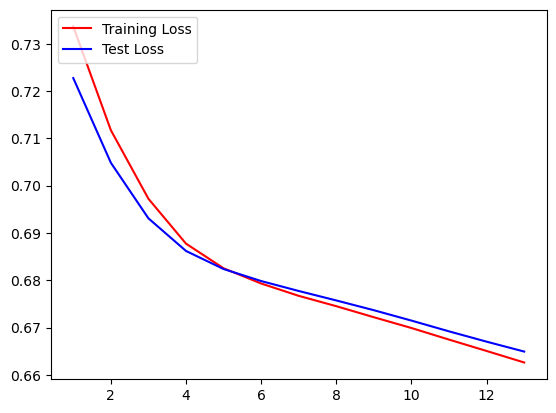

Epoch: 13 Train_Loss: 0.6604837467715998 Train_Accuracy: 0.5006
Epoch: 13 Test_Loss: 0.6629192426800727 Test_Accuracy: 0.5047


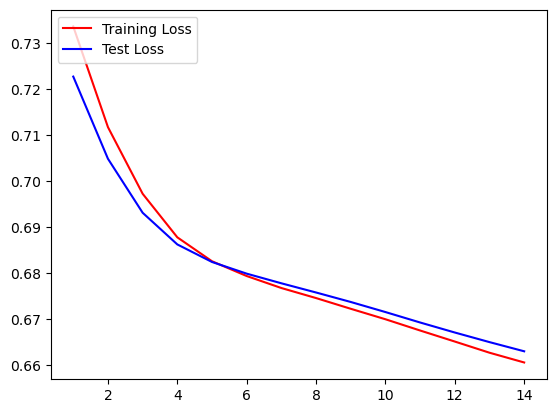

Epoch: 14 Train_Loss: 0.6583372942960946 Train_Accuracy: 0.501125
Epoch: 14 Test_Loss: 0.6609722316265106 Test_Accuracy: 0.5056


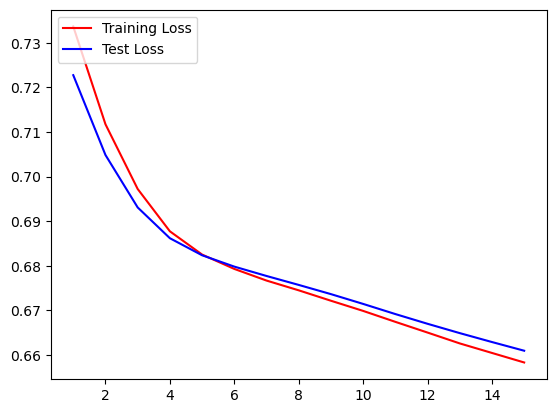

Epoch: 15 Train_Loss: 0.6562583678087611 Train_Accuracy: 0.502025
Epoch: 15 Test_Loss: 0.6590384230017662 Test_Accuracy: 0.5067


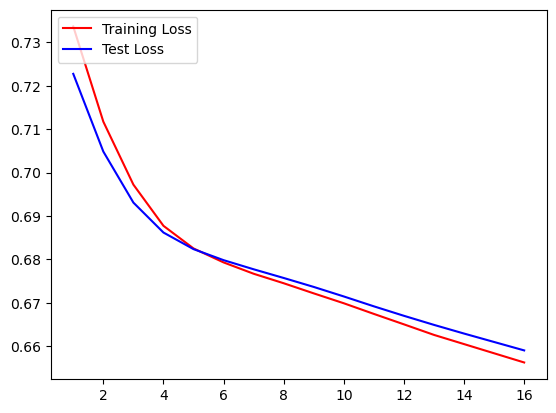

Epoch: 16 Train_Loss: 0.6541217075791329 Train_Accuracy: 0.503375
Epoch: 16 Test_Loss: 0.6571027979254722 Test_Accuracy: 0.5079


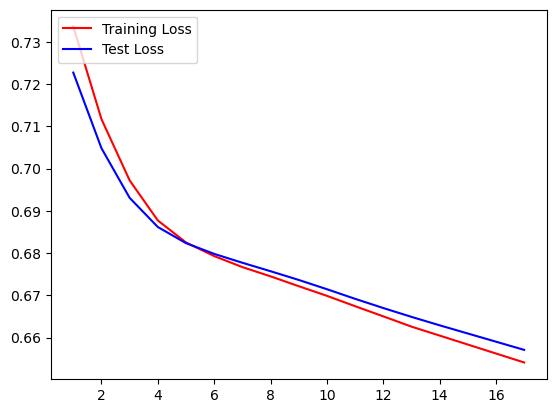

Epoch: 17 Train_Loss: 0.6519608994957747 Train_Accuracy: 0.50515
Epoch: 17 Test_Loss: 0.655145688354969 Test_Accuracy: 0.5105


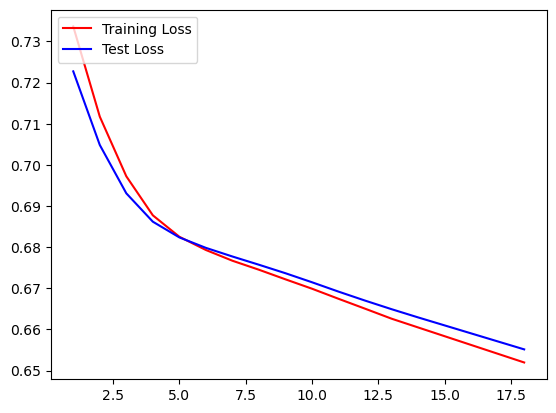

Epoch: 18 Train_Loss: 0.6498229780774207 Train_Accuracy: 0.50685
Epoch: 18 Test_Loss: 0.6532251477241516 Test_Accuracy: 0.5109


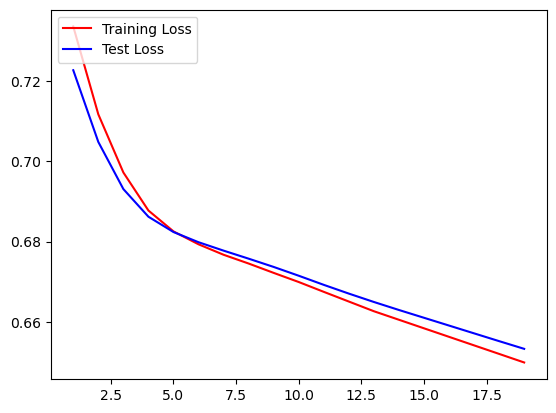

Epoch: 19 Train_Loss: 0.647546253006929 Train_Accuracy: 0.50915
Epoch: 19 Test_Loss: 0.6512759327888489 Test_Accuracy: 0.5133


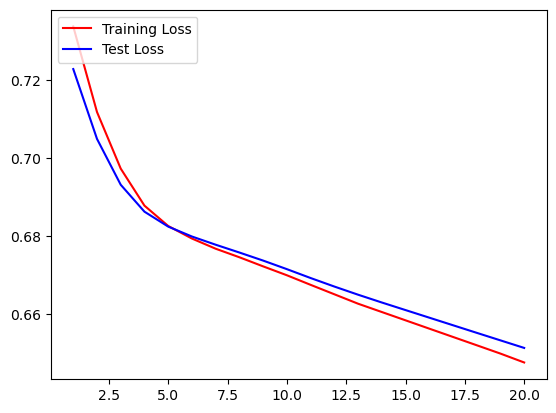

Epoch: 20 Train_Loss: 0.6455863513005008 Train_Accuracy: 0.511275
Epoch: 20 Test_Loss: 0.6493604928255081 Test_Accuracy: 0.5158


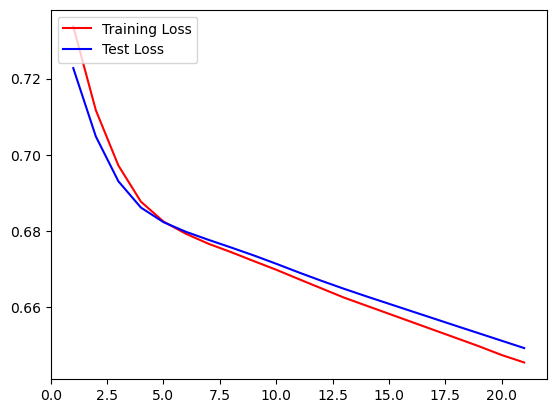

Epoch: 21 Train_Loss: 0.6433279343471405 Train_Accuracy: 0.51365
Epoch: 21 Test_Loss: 0.6474341720342636 Test_Accuracy: 0.5183


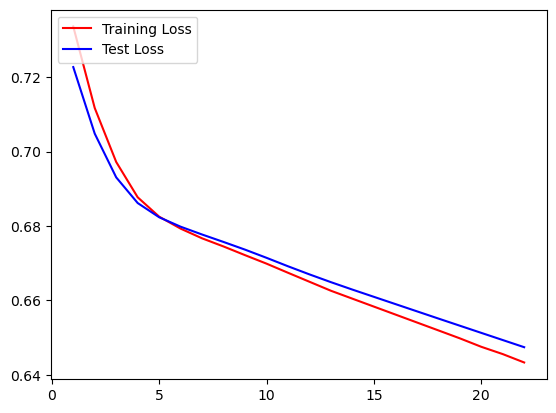

Epoch: 22 Train_Loss: 0.6414403372509464 Train_Accuracy: 0.51755
Epoch: 22 Test_Loss: 0.6454366862773895 Test_Accuracy: 0.5208


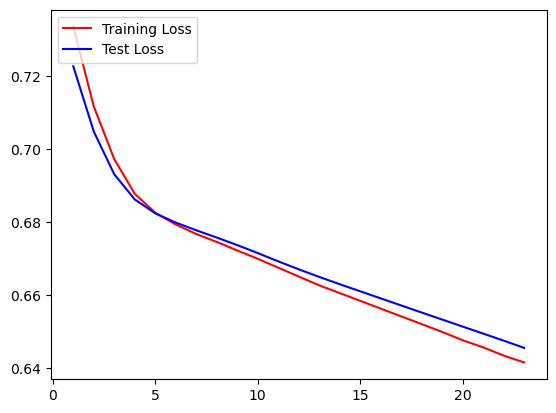

Epoch: 23 Train_Loss: 0.6392363795808925 Train_Accuracy: 0.5203
Epoch: 23 Test_Loss: 0.6433995842933655 Test_Accuracy: 0.5238


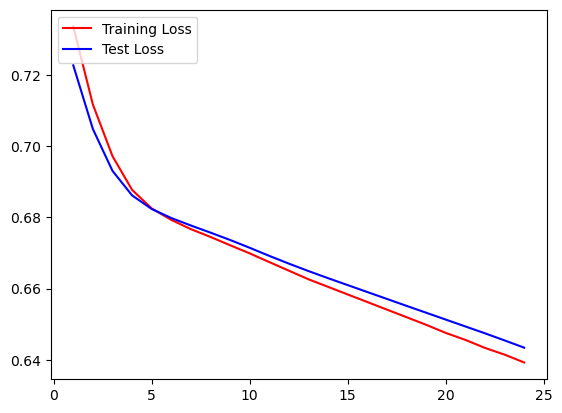

Epoch: 24 Train_Loss: 0.6370125204134899 Train_Accuracy: 0.52375
Epoch: 24 Test_Loss: 0.6413600742816925 Test_Accuracy: 0.5274


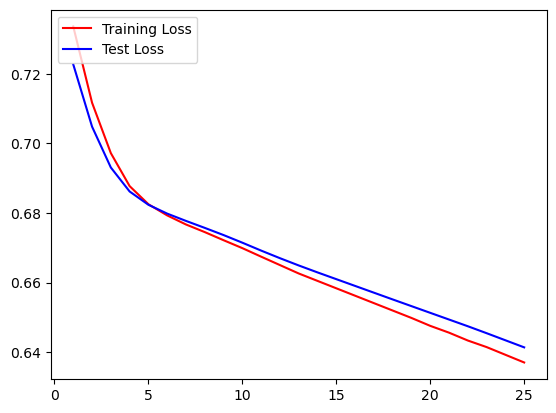

Epoch: 25 Train_Loss: 0.634943036896408 Train_Accuracy: 0.527675
Epoch: 25 Test_Loss: 0.6393587321043015 Test_Accuracy: 0.5292


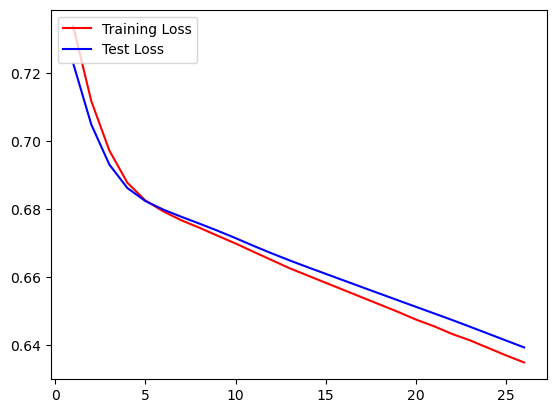

Epoch: 26 Train_Loss: 0.6329737001923239 Train_Accuracy: 0.5296
Epoch: 26 Test_Loss: 0.6373222410678864 Test_Accuracy: 0.5326


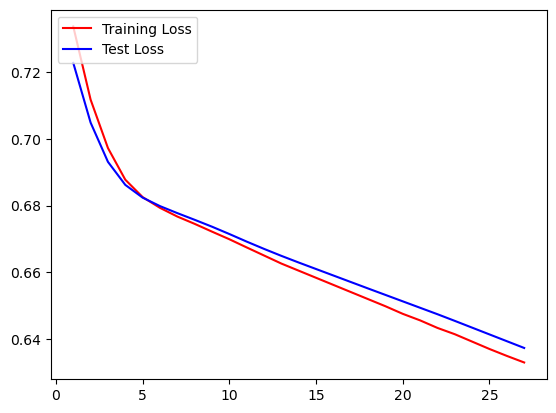

Epoch: 27 Train_Loss: 0.6303956876894471 Train_Accuracy: 0.53275
Epoch: 27 Test_Loss: 0.6352448180317879 Test_Accuracy: 0.5348


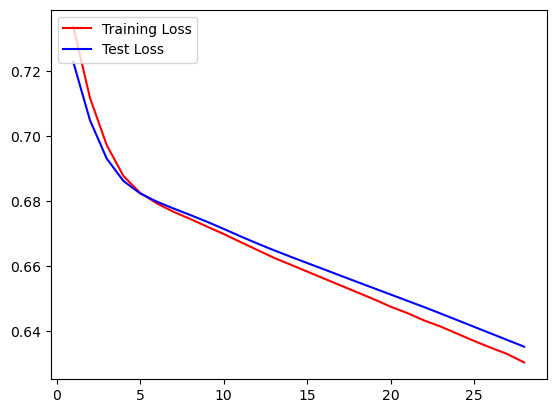

Epoch: 28 Train_Loss: 0.6284714375331903 Train_Accuracy: 0.5358
Epoch: 28 Test_Loss: 0.6331634193658828 Test_Accuracy: 0.5378


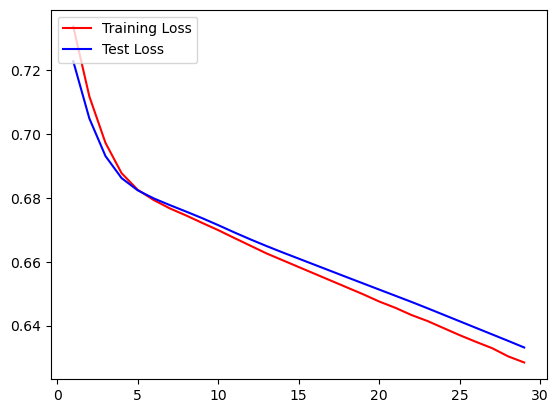

Epoch: 29 Train_Loss: 0.6265189135150545 Train_Accuracy: 0.538125
Epoch: 29 Test_Loss: 0.6310869142413139 Test_Accuracy: 0.5407


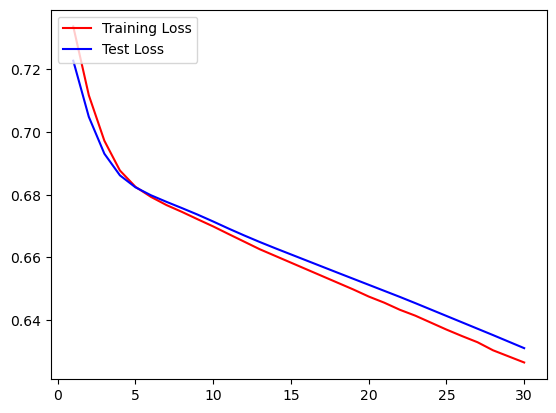

Epoch: 30 Train_Loss: 0.6243119892800689 Train_Accuracy: 0.540925
Epoch: 30 Test_Loss: 0.6291635438799859 Test_Accuracy: 0.5423


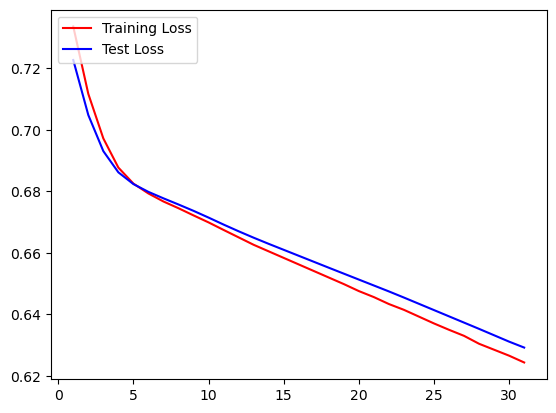

Epoch: 31 Train_Loss: 0.6223278968197525 Train_Accuracy: 0.54275
Epoch: 31 Test_Loss: 0.6273347839713097 Test_Accuracy: 0.5441


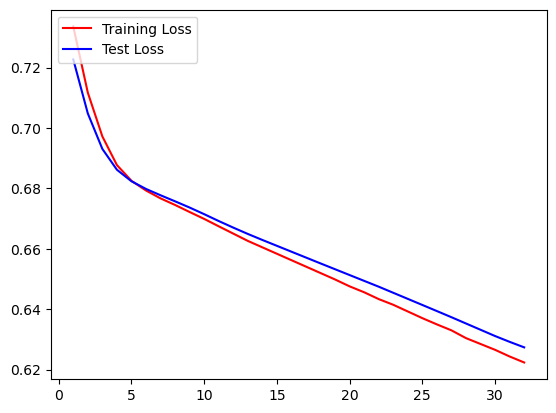

Epoch: 32 Train_Loss: 0.6205869153806358 Train_Accuracy: 0.546125
Epoch: 32 Test_Loss: 0.6255625247955322 Test_Accuracy: 0.546


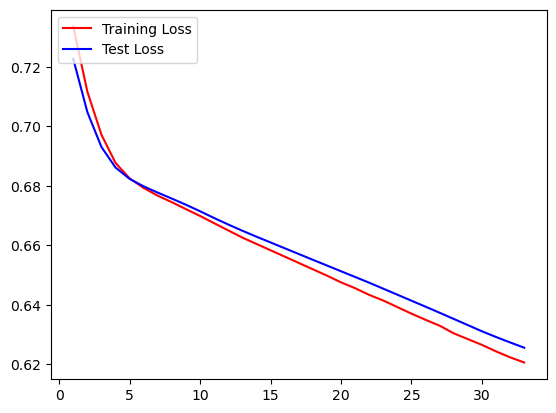

Epoch: 33 Train_Loss: 0.6185378177910094 Train_Accuracy: 0.5485
Epoch: 33 Test_Loss: 0.6238941252231598 Test_Accuracy: 0.549


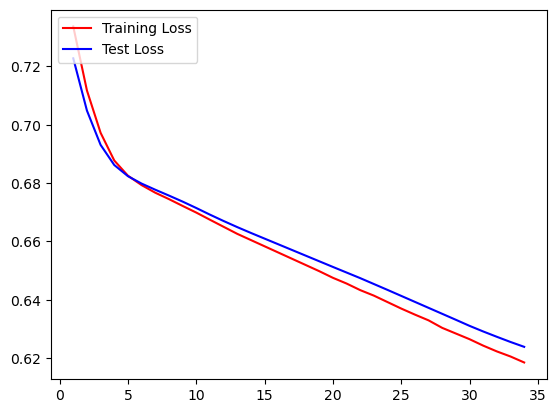

Epoch: 34 Train_Loss: 0.6169198337633899 Train_Accuracy: 0.55115
Epoch: 34 Test_Loss: 0.6223311215639115 Test_Accuracy: 0.5512


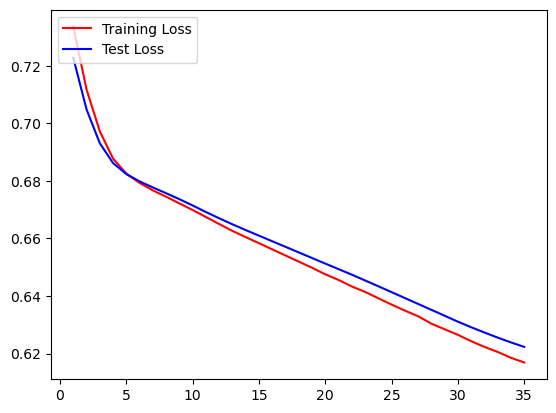

Epoch: 35 Train_Loss: 0.6156583956092786 Train_Accuracy: 0.552925
Epoch: 35 Test_Loss: 0.6208414450287819 Test_Accuracy: 0.5547


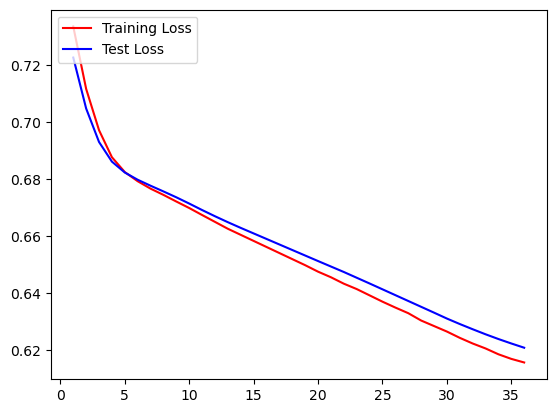

Epoch: 36 Train_Loss: 0.6139389485310597 Train_Accuracy: 0.555875
Epoch: 36 Test_Loss: 0.6194408446550369 Test_Accuracy: 0.5573


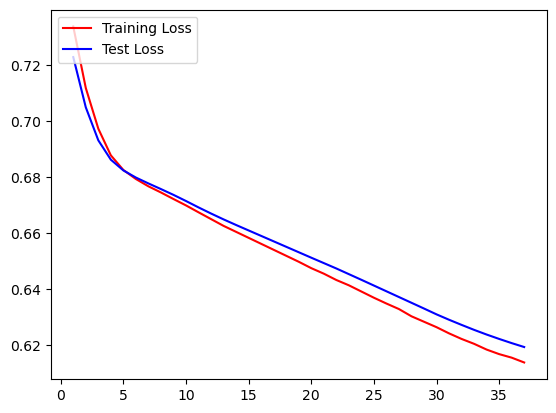

Epoch: 37 Train_Loss: 0.6123031104446217 Train_Accuracy: 0.55825
Epoch: 37 Test_Loss: 0.6180685371160507 Test_Accuracy: 0.5602


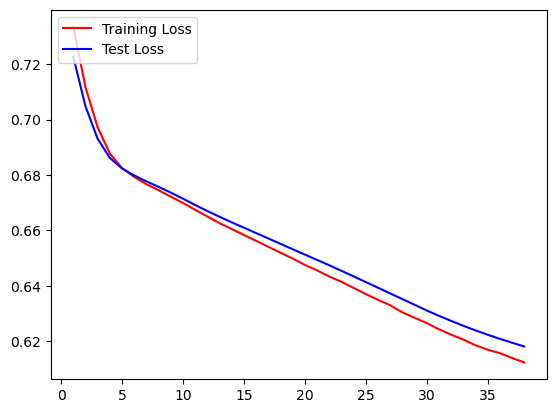

Epoch: 38 Train_Loss: 0.6109351136122539 Train_Accuracy: 0.5609
Epoch: 38 Test_Loss: 0.6167327031493187 Test_Accuracy: 0.5617


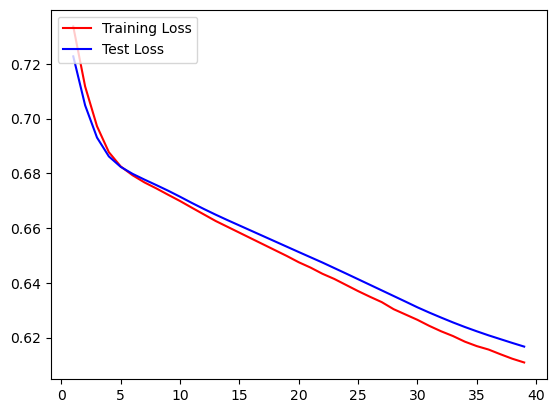

Epoch: 39 Train_Loss: 0.6095376808172578 Train_Accuracy: 0.5634
Epoch: 39 Test_Loss: 0.6154617726802826 Test_Accuracy: 0.5635


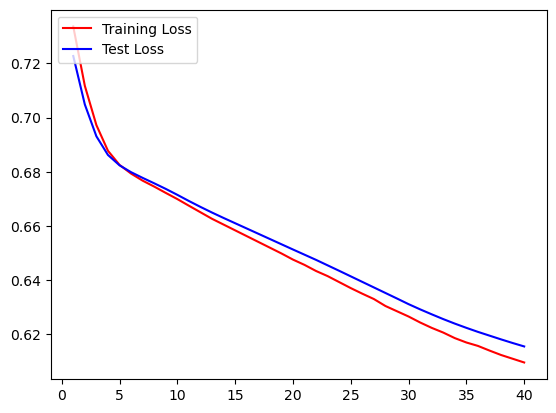

Epoch: 40 Train_Loss: 0.6082560252991451 Train_Accuracy: 0.5645
Epoch: 40 Test_Loss: 0.6142451941967011 Test_Accuracy: 0.566


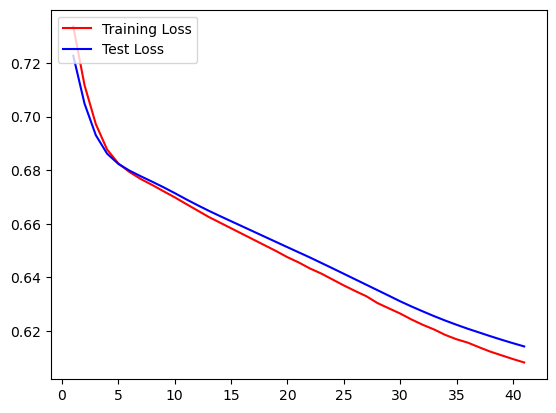

Epoch: 41 Train_Loss: 0.6071126514179691 Train_Accuracy: 0.5663
Epoch: 41 Test_Loss: 0.6130783081054687 Test_Accuracy: 0.5664


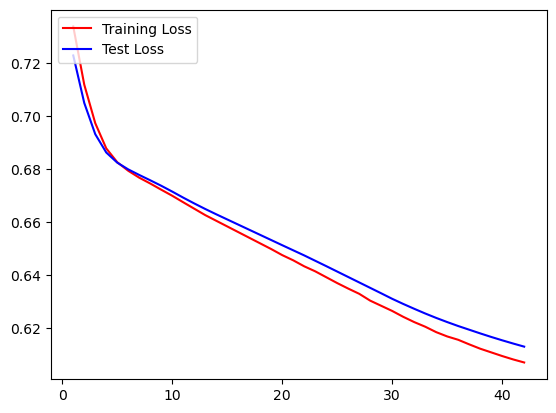

Epoch: 42 Train_Loss: 0.6057922938826737 Train_Accuracy: 0.56885
Epoch: 42 Test_Loss: 0.6119559556245804 Test_Accuracy: 0.5687


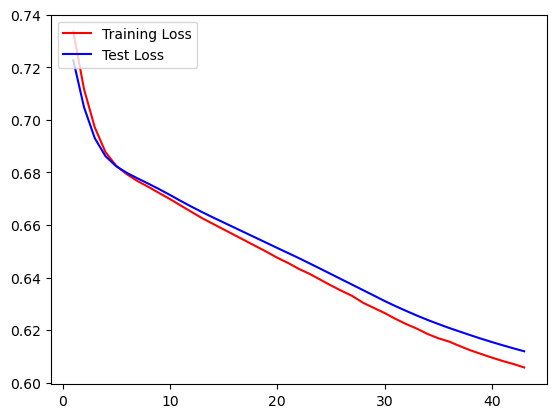

Epoch: 43 Train_Loss: 0.6042782865512143 Train_Accuracy: 0.570825
Epoch: 43 Test_Loss: 0.6108492314815521 Test_Accuracy: 0.5704


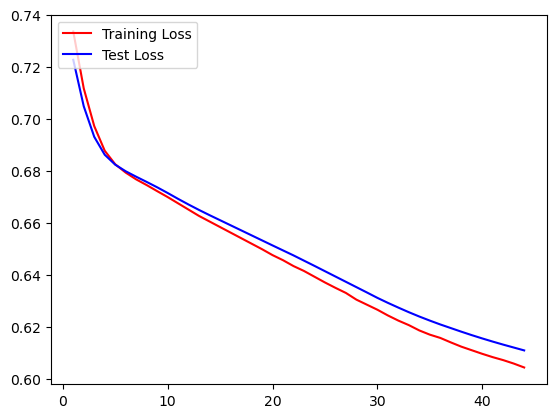

Epoch: 44 Train_Loss: 0.6032072184192148 Train_Accuracy: 0.57295
Epoch: 44 Test_Loss: 0.6097962856292725 Test_Accuracy: 0.5724


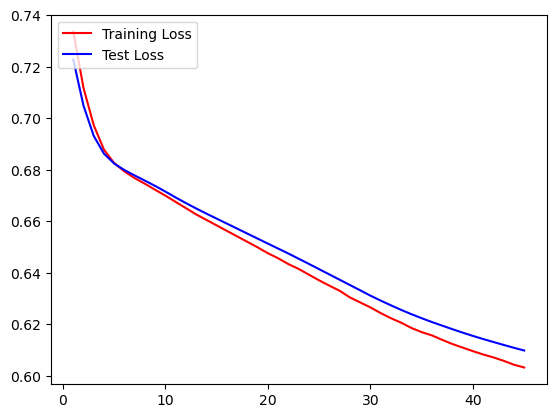

Epoch: 45 Train_Loss: 0.6020264705275274 Train_Accuracy: 0.57495
Epoch: 45 Test_Loss: 0.6087425455451012 Test_Accuracy: 0.5754


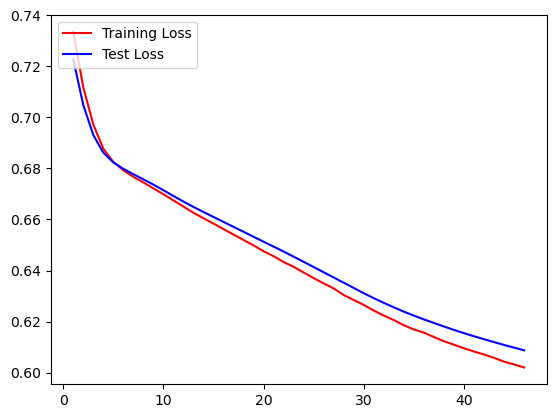

Epoch: 46 Train_Loss: 0.6008788612997455 Train_Accuracy: 0.577425
Epoch: 46 Test_Loss: 0.6077245905995369 Test_Accuracy: 0.5764


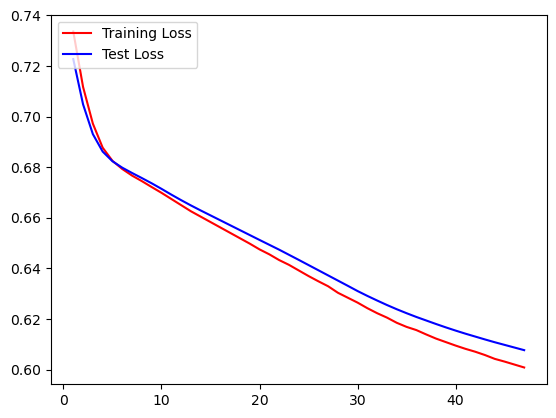

Epoch: 47 Train_Loss: 0.599513847736796 Train_Accuracy: 0.580625
Epoch: 47 Test_Loss: 0.606737244129181 Test_Accuracy: 0.5772


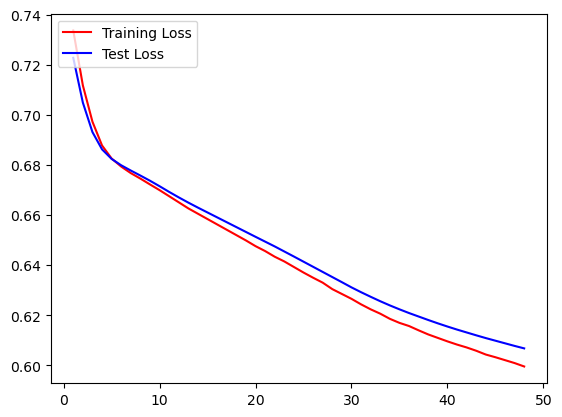

Epoch: 48 Train_Loss: 0.5989090853435978 Train_Accuracy: 0.582075
Epoch: 48 Test_Loss: 0.6057718321681023 Test_Accuracy: 0.5779


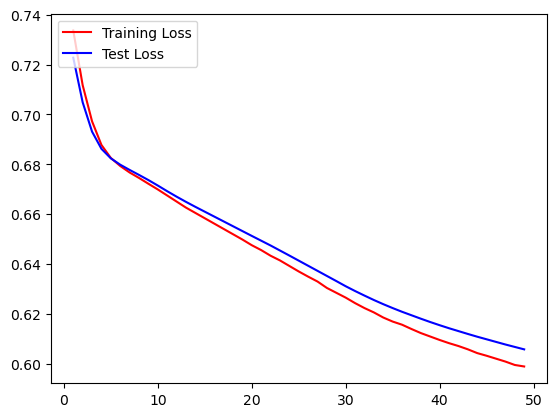

Epoch: 49 Train_Loss: 0.5976027508450162 Train_Accuracy: 0.584325
Epoch: 49 Test_Loss: 0.6048027783632278 Test_Accuracy: 0.579


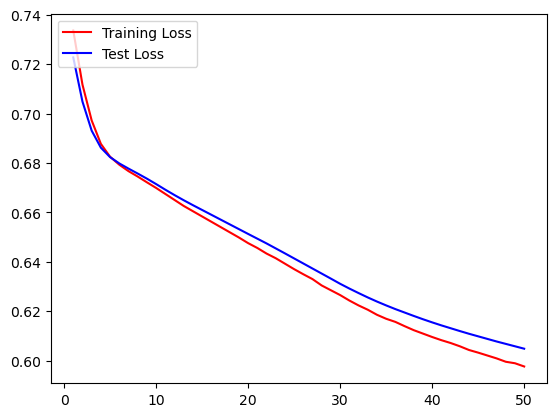

Epoch: 50 Train_Loss: 0.5963002606561989 Train_Accuracy: 0.58725
Epoch: 50 Test_Loss: 0.6038439512252808 Test_Accuracy: 0.5799


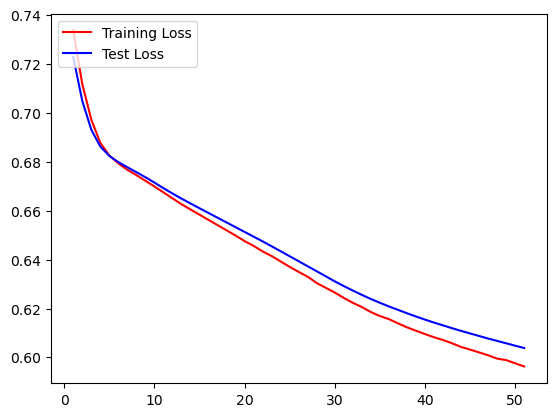

Epoch: 51 Train_Loss: 0.5953284904455683 Train_Accuracy: 0.589375
Epoch: 51 Test_Loss: 0.6028703138232231 Test_Accuracy: 0.5822


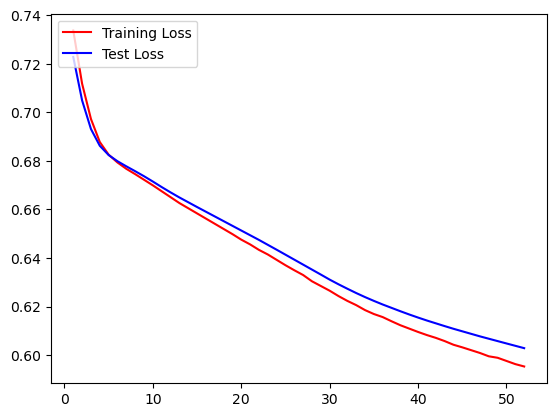

Epoch: 52 Train_Loss: 0.5947148853046879 Train_Accuracy: 0.5915
Epoch: 52 Test_Loss: 0.6019511103630066 Test_Accuracy: 0.5837


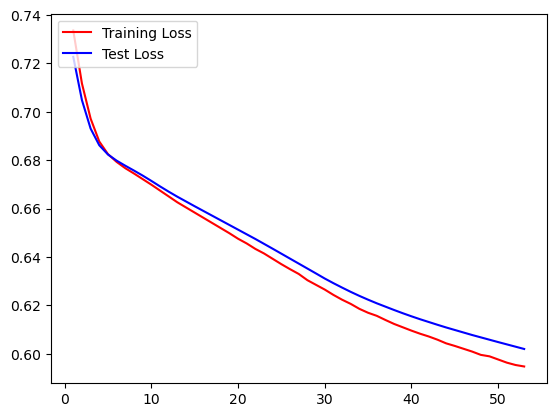

Epoch: 53 Train_Loss: 0.5933032396492685 Train_Accuracy: 0.59315
Epoch: 53 Test_Loss: 0.6010545030236244 Test_Accuracy: 0.5839


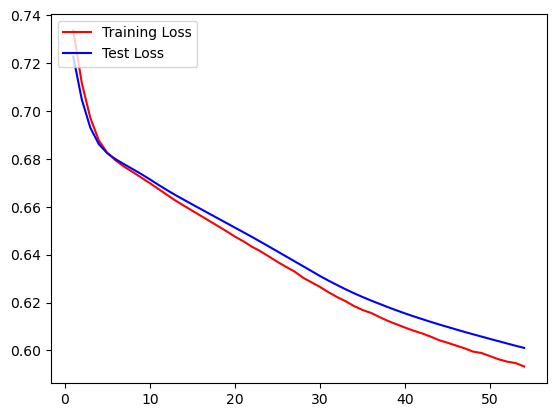

Epoch: 54 Train_Loss: 0.5923023466851302 Train_Accuracy: 0.595325
Epoch: 54 Test_Loss: 0.6001533344388008 Test_Accuracy: 0.5877


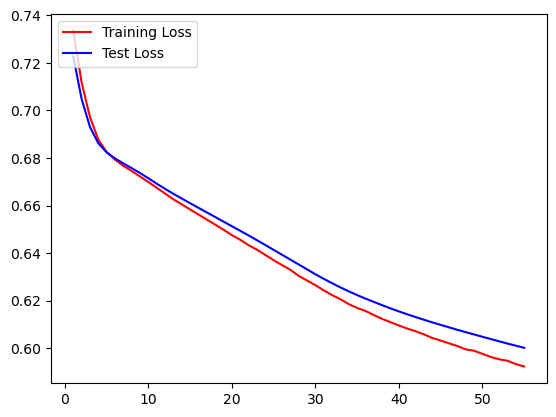

Epoch: 55 Train_Loss: 0.5916476105428805 Train_Accuracy: 0.598275
Epoch: 55 Test_Loss: 0.5992891028523445 Test_Accuracy: 0.5889


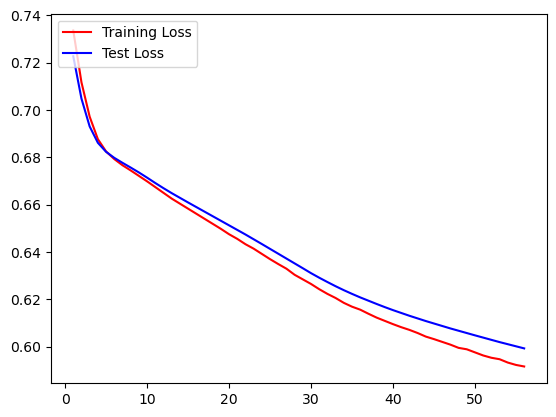

Epoch: 56 Train_Loss: 0.5905081739850865 Train_Accuracy: 0.601125
Epoch: 56 Test_Loss: 0.5984305307269097 Test_Accuracy: 0.5899


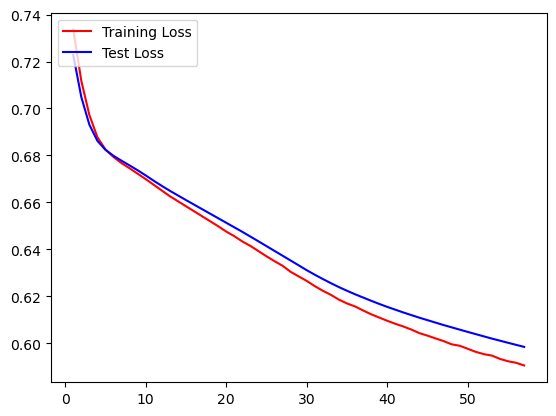

Epoch: 57 Train_Loss: 0.5894009505107904 Train_Accuracy: 0.602775
Epoch: 57 Test_Loss: 0.5976316943764687 Test_Accuracy: 0.5911


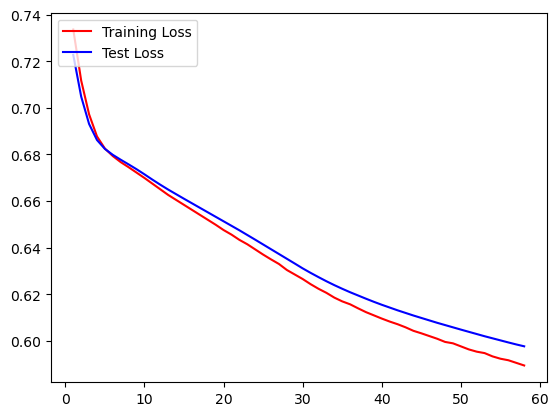

Epoch: 58 Train_Loss: 0.588756232504632 Train_Accuracy: 0.603625
Epoch: 58 Test_Loss: 0.5968310177326203 Test_Accuracy: 0.5936


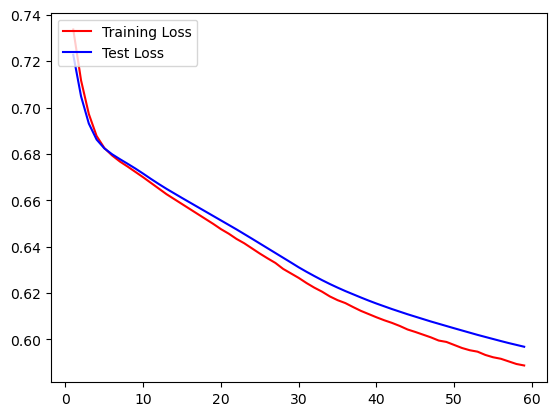

Epoch: 59 Train_Loss: 0.587961932656112 Train_Accuracy: 0.606225
Epoch: 59 Test_Loss: 0.5960674494504928 Test_Accuracy: 0.5965


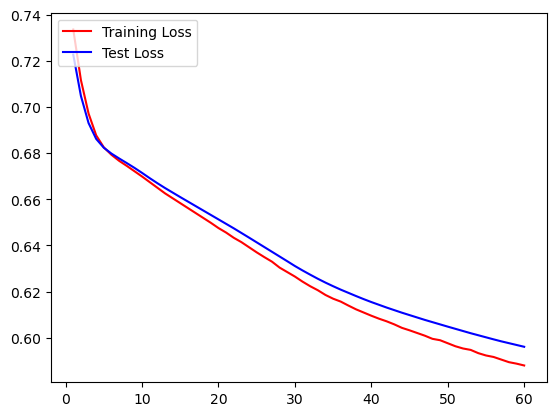

Epoch: 60 Train_Loss: 0.587002181703118 Train_Accuracy: 0.6092
Epoch: 60 Test_Loss: 0.5953230187296867 Test_Accuracy: 0.5978


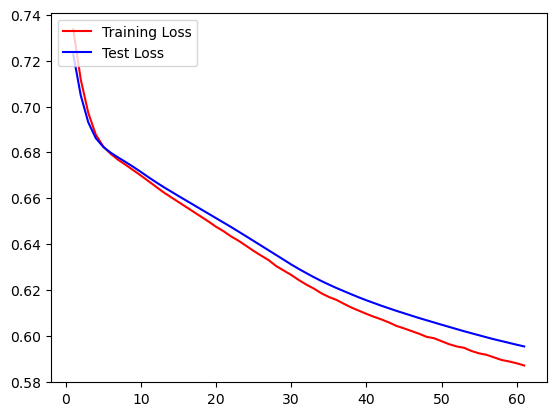

Epoch: 61 Train_Loss: 0.5859672499310439 Train_Accuracy: 0.61085
Epoch: 61 Test_Loss: 0.594603818655014 Test_Accuracy: 0.5991


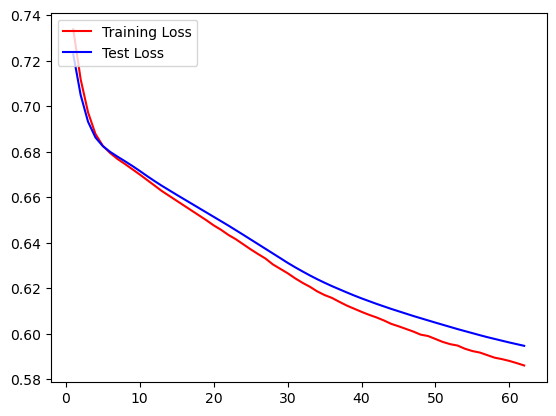

Epoch: 62 Train_Loss: 0.585196267267701 Train_Accuracy: 0.61245
Epoch: 62 Test_Loss: 0.5939124956727028 Test_Accuracy: 0.6014


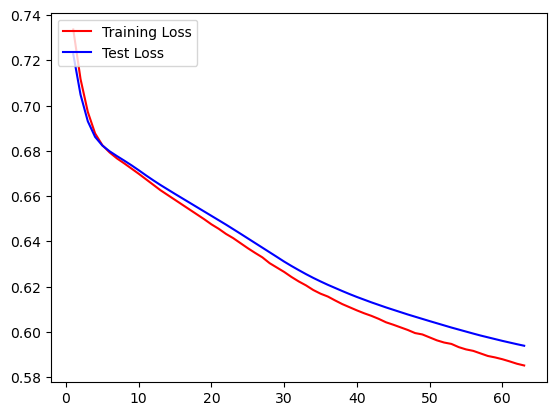

Epoch: 63 Train_Loss: 0.5846302858583486 Train_Accuracy: 0.614975
Epoch: 63 Test_Loss: 0.5932063564658165 Test_Accuracy: 0.6027


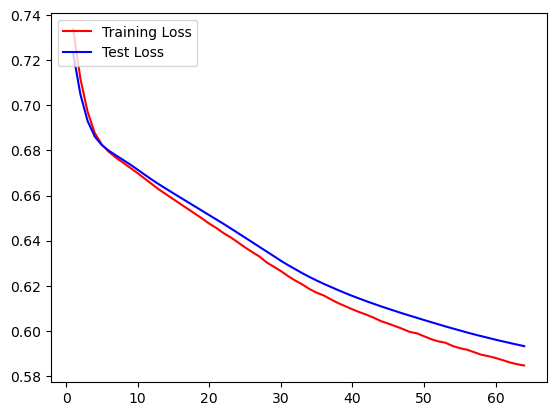

Epoch: 64 Train_Loss: 0.5835739085628728 Train_Accuracy: 0.615575
Epoch: 64 Test_Loss: 0.5925366282463074 Test_Accuracy: 0.6036


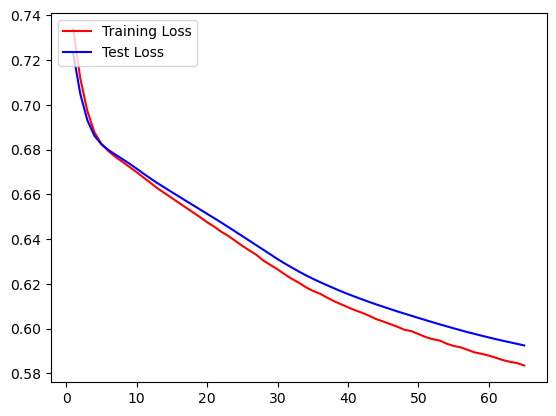

Epoch: 65 Train_Loss: 0.5828032975743531 Train_Accuracy: 0.618125
Epoch: 65 Test_Loss: 0.5918709427118302 Test_Accuracy: 0.6063


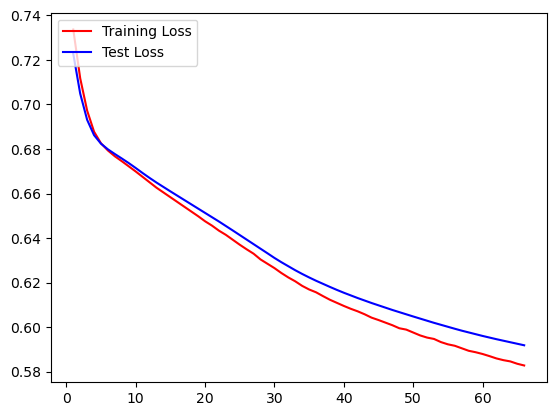

In [ ]:
from IPython.display import clear_output
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')
weights = []
loss_fn = nn.BCEWithLogitsLoss()
# loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(weights))
model = TextClassificationModel(pretrained_embeddings, 1)
gpus = torch.cuda.device_count()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if gpus > 1:
    print("Let's use", gpus, "GPUs!")

loss_fn.to(device)
model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.0001)

epochs = 500

training_losses = [ None for i in range(epochs)]
test_losses = [ None for i in range(epochs)]
epoch_count = [i for i in range(1, epochs+1)]
recalls = [ None for i in range(epochs)]
precisions = [ None for i in range(epochs)]
accuracys = [ None for i in range(epochs)]
for e in range(epochs):
    model.train()
    epoch_loss = 0

    losses = []
    train_predictions_store = []
    train_labels_store = []
    for batch_id, batch in enumerate(train_dataloader):

        ids = batch['indices'].to(device)
        labels = batch['labels'].to(device)
        optimizer.zero_grad()
        outputs = model(ids)
        outputs = torch.reshape(outputs, (-1,))
        probs = torch.sigmoid(outputs)
        preds = torch.where(outputs > 0.5, 1, 0)
        loss = loss_fn(outputs, labels)

        labels = labels.to(torch.device("cpu")).numpy()
        preds = preds.to(torch.device("cpu")).numpy()
        for i in range(len(preds)):
            train_predictions_store.append(preds[i])
            train_labels_store.append(labels[i])

        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    epoch_loss = np.mean(losses)

    training_losses[e] = epoch_loss
    train_accuracy = accuracy_score(train_labels_store, train_predictions_store)

    #  rp = classification_report(train_labels_store, train_predictions_store, target_names=['0','1'])
    #  print(rp)



    torch.save(model.state_dict(), 'Models/CNN_model_epoch_{}.pt'.format(e))

    # Evaluate on test set
    with torch.no_grad():
        model.eval()
        test_loss = []
        test_correct_predictions = 0
        test_predictions_store = []
        test_labels_store = []

        for batch_id, batch in enumerate(test_dataloader):
            ids = batch['indices'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(ids)
            outputs = torch.reshape(outputs, (-1,))

            probs = torch.sigmoid(outputs)
            preds = torch.where(outputs > 0.5, 1, 0)
            loss = loss_fn(outputs, labels)

            test_correct_predictions += torch.sum(preds == labels)
            test_loss.append(loss.item())

            labels = labels.to(torch.device("cpu")).numpy()
            preds = preds.to(torch.device("cpu")).numpy()
            for i in range(len(preds)):
                test_predictions_store.append(preds[i])
                test_labels_store.append(labels[i])

        test_loss = np.mean(test_loss)
        test_accuracy = accuracy_score(test_labels_store, test_predictions_store)
        test_losses[e] = test_loss

        #rp = classification_report(test_labels_store, test_predictions_store, target_names=['0','1'])
        #print(rp)
        print('Epoch: {} Train_Loss: {} Train_Accuracy: {}'.format(e, epoch_loss, train_accuracy))
        print('Epoch: {} Test_Loss: {} Test_Accuracy: {}'.format(e, test_loss, test_accuracy))

        plt.plot(epoch_count, training_losses, 'r', label='Training Loss')
        plt.plot(epoch_count, test_losses, 'b', label='Test Loss')
        plt.legend(loc="upper left")

        plt.show()